In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import nibabel as nib

from scipy.stats import multivariate_normal
from skimage.exposure import equalize_hist
from scipy.ndimage.measurements import label
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.morphology import binary_erosion, binary_dilation
import statsmodels.api as sm

In [2]:
def find_coords(pts, lab):
    y,x,z = np.where(pts == lab)
    return np.mean(y), np.mean(x), np.mean(z)


def fit_lines(pt1,pt2):
    x_coords = np.concatenate([[pt1[0]], [pt2[0]]])
    y_coords = np.concatenate([[pt1[1]], [pt2[1]]])
    
    intercept = np.ones(len(x_coords))
    X = np.transpose(np.stack([intercept, x_coords]))
    Y = np.transpose(y_coords)

    model = sm.OLS(Y, X).fit()
    return model.params


def create_hv_mask(rhv_coef, mhv_coef, lhv_coef, pts):
    mesh = np.meshgrid(range(pts.shape[0]), range(pts.shape[1]), range(pts.shape[2]))
    
    rhv_line = rhv_coef[0] + mesh[0] * rhv_coef[1]
    mhv_line = mhv_coef[0] + mesh[0] * mhv_coef[1]
    lhv_line = lhv_coef[0] + mesh[0] * lhv_coef[1]
    
    if lhv_coef[1] >= 0:
        lower = (mesh[1] >= rhv_line)*1
        rmid = ((mesh[1] >= mhv_line) & (mesh[1] < rhv_line) & (lower == 0))*2
        lmid = ((mesh[1] >= lhv_line) & (mesh[1] < mhv_line) & (lower == 0) & (rmid == 0))*3
        #upper = ((mesh[1] < lhv_line)   & (lower == 0) & (rmid == 0) & (lmid == 0))  *4
        upper = ((mesh[1] < lhv_line) & (rmid == 0) & (lmid == 0))  *4
        lower = ((mesh[1] >= rhv_line) & (upper == 0))*1

    elif lhv_coef[1] <0:
        lower = (mesh[1] >= rhv_line)*1
        rmid = ((mesh[1] >= mhv_line) & (mesh[1] < rhv_line) & (lower == 0))*2
        lmid = ((mesh[1] < lhv_line) & (mesh[1] < mhv_line) & (lower == 0) & (rmid == 0))*3
        #upper = ((mesh[1] < lhv_line)   & (lower == 0) & (rmid == 0) & (lmid == 0))  *4
        upper = ((mesh[1] >= lhv_line) & (rmid == 0) & (lmid == 0))  *4
        lower = ((mesh[1] >= rhv_line) & (upper == 0))*1
        
    
    return lower + rmid + lmid + upper


def create_cou_mask(pts, liv):

    # find coordinates of ivc
    ivc_y,ivc_x,ivc_z = find_coords(pts, 1)
    # find coordinates of right hepatic vein
    rhv_y,rhv_x,rhv_z = find_coords(pts, 2)
    # find coordinates of middle hepatic vein
    mhv_y,mhv_x,mhv_z = find_coords(pts, 3)
    # find coordinates of left hepatic vein
    lhv_y,lhv_x,lhv_z = find_coords(pts, 5)
    
    # find coefficients of hepatic vein dividing lines
    rhv_coef = fit_lines( (ivc_x,ivc_y), (rhv_x, rhv_y) )
    mhv_coef = fit_lines( (ivc_x,ivc_y), (mhv_x, mhv_y) )
    lhv_coef = fit_lines( (ivc_x,ivc_y), (lhv_x, lhv_y) )
    
    # create mask for ivc to each hepatic vein
    hv_mask = create_hv_mask(rhv_coef, mhv_coef, lhv_coef, pts)
    
    
    ###############################################################################
    # segments by portal vein
    pv1_y,pv1_x,pv1_z = find_coords(pts, 9)
    pv2_y,pv2_x,pv2_z = find_coords(pts, 10)
    
    mesh = np.meshgrid(range(pts.shape[0]), range(pts.shape[1]), range(pts.shape[2]))
    
    hv_mask[ (mesh[2] <= pv2_z) & (hv_mask == 1) ] = 5
    hv_mask[ (mesh[2] <= pv2_z) & (hv_mask == 2) ] = 6
    hv_mask[ (mesh[2] > pv1_z) & (hv_mask == 3) ] = 7
    hv_mask[ (mesh[2] > pv1_z) & (hv_mask == 4) ] = 8
    
    
    # include segment 1
    hv_mask = (hv_mask + 1) * liv
    hv_mask[pts == 7] = 1
    
    # associate labels with segments
    cou_mask = np.zeros(hv_mask.shape)
    cou_mask[hv_mask == 1] = 1
    cou_mask[hv_mask == 9] = 2
    cou_mask[hv_mask == 5] = 3
    cou_mask[hv_mask == 8] = 4
    cou_mask[hv_mask == 7] = 5
    cou_mask[hv_mask == 6] = 6
    cou_mask[hv_mask == 2] = 7
    cou_mask[hv_mask == 3] = 8
    cou_mask[hv_mask == 4] = 9
    
    return cou_mask

In [208]:
case_id = 'f_2429.nii'

whole_seg_path = r'N:\2_Analysis\automated_analysis\flint_segmentations\flint_additions\whole_liver_seg/'
twopt_path = r'N:\2_Analysis\automated_analysis\flint_segmentations\flint_additions\2-point annotations/'

liv_ni = nib.load(os.path.join(whole_seg_path, case_id))
twopt_ni = nib.load(os.path.join(twopt_path, case_id + '.gz'))

liv_whole = liv_ni.get_fdata()
two_pt = twopt_ni.get_fdata()

liv_whole.shape, two_pt.shape

((224, 224, 25), (224, 224, 25))

In [209]:
mesh = np.meshgrid(two_pt.shape[0], two_pt.shape[1], two_pt.shape[2])
type(mesh)

list

In [210]:
# find coordinates of ivc
ivc_y,ivc_x,ivc_z = find_coords(two_pt, 1)
# find coordinates of right hepatic vein
rhv_y,rhv_x,rhv_z = find_coords(two_pt, 2)
# find coordinates of middle hepatic vein
mhv_y,mhv_x,mhv_z = find_coords(two_pt, 3)
# find coordinates of left hepatic vein
lhv_y,lhv_x,lhv_z = find_coords(two_pt, 5)

print(ivc_y,ivc_x,ivc_z)
print(rhv_y,rhv_x,rhv_z)
print(mhv_y,mhv_x,mhv_z)
print(lhv_y,lhv_x,lhv_z)

123.0 108.0 15.0
135.0 109.0 15.0
137.0 124.0 15.0
137.0 145.0 11.0


In [211]:
rhv_coef = fit_lines( (ivc_x,ivc_y), (rhv_x, rhv_y) )
mhv_coef = fit_lines( (ivc_x,ivc_y), (mhv_x, mhv_y) )
lhv_coef = fit_lines( (ivc_x,ivc_y), (lhv_x, lhv_y) )

print(rhv_coef)
print(mhv_coef)
print(lhv_coef)

[-1173.    12.]
[28.5    0.875]
[82.13513514  0.37837838]


In [212]:
hv_mask = create_hv_mask(rhv_coef, mhv_coef, lhv_coef, two_pt)
hv_mask.shape

(224, 224, 25)

<function matplotlib.pyplot.show(close=None, block=None)>

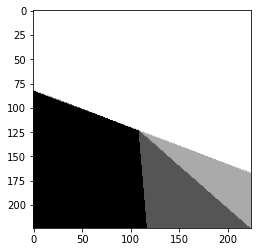

In [213]:
plt.imshow(hv_mask[:,:,12],cmap='gray')
plt.show

In [214]:
cou = create_cou_mask(two_pt, liv_whole)

<function matplotlib.pyplot.show(close=None, block=None)>

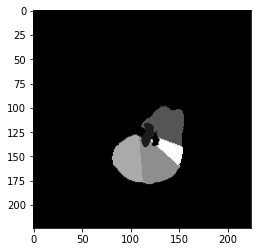

In [215]:
plt.imshow(cou[:,:,12],cmap='gray')
plt.show

In [216]:
output_dir = r'N:\2_Analysis\automated_analysis\flint_segmentations\flint_additions\segmental_seg/'

cou_ni = nib.Nifti1Image(cou, liv_ni.affine)
#hv_ni = nib.Nifti1Image(hv_mask, liv_ni.affine)

nib.save(cou_ni, os.path.join(output_dir, case_id))
#nib.save(hv_ni, 'test_hv.nii')

In [27]:
case_id1 = 'f_3325.nii'

whole_seg_path1 = r'N:\2_Analysis\automated_analysis\flint_segmentations\flint_additions\whole_liver_seg/'
twopt_path1 = r'N:\2_Analysis\automated_analysis\flint_segmentations\flint_additions\2-point annotations/'

liv_ni1 = nib.load(os.path.join(whole_seg_path1, case_id1))
twopt_ni1 = nib.load(os.path.join(twopt_path1, case_id1 + '.gz'))

liv_whole1 = liv_ni1.get_fdata()
two_pt1 = twopt_ni1.get_fdata()

liv_whole1.shape, two_pt1.shape

((224, 224, 31), (224, 224, 31))

In [28]:
# find coordinates of ivc
ivc_y,ivc_x,ivc_z = find_coords(two_pt1, 1)
# find coordinates of right hepatic vein
rhv_y,rhv_x,rhv_z = find_coords(two_pt1, 2)
# find coordinates of middle hepatic vein
mhv_y,mhv_x,mhv_z = find_coords(two_pt1, 3)
# find coordinates of left hepatic vein
lhv_y,lhv_x,lhv_z = find_coords(two_pt1, 5)

print(ivc_y,ivc_x,ivc_z)
print(rhv_y,rhv_x,rhv_z)
print(mhv_y,mhv_x,mhv_z)
print(lhv_y,lhv_x,lhv_z)

115.5 107.0 17.5
130.0 108.0 22.0
123.0 126.0 22.0
118.0 168.0 13.0


In [29]:
rhv_coef = fit_lines( (ivc_x,ivc_y), (rhv_x, rhv_y) )
mhv_coef = fit_lines( (ivc_x,ivc_y), (mhv_x, mhv_y) )
lhv_coef = fit_lines( (ivc_x,ivc_y), (lhv_x, lhv_y) )

print(rhv_coef)
print(mhv_coef)
print(lhv_coef)

[-1436.     14.5]
[73.26315789  0.39473684]
[1.11114754e+02 4.09836066e-02]


In [30]:
hv_mask = create_hv_mask(rhv_coef, mhv_coef, lhv_coef, two_pt1)
hv_mask.shape

(224, 224, 31)

<function matplotlib.pyplot.show(close=None, block=None)>

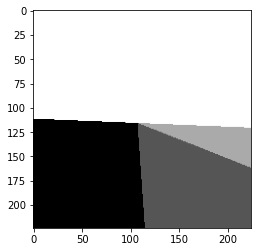

In [31]:
plt.imshow(hv_mask[:,:,15],cmap='gray')
plt.show

In [17]:
cou = create_cou_mask(two_pt1, liv_whole1)

<function matplotlib.pyplot.show(close=None, block=None)>

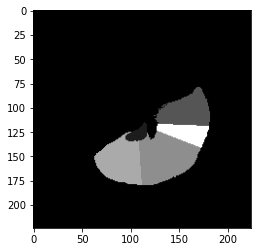

In [18]:
plt.imshow(cou[:,:,15],cmap='gray')
plt.show